In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import raybay

In [25]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
#res_dummy = np.load('dummy/res_linear_quadratic_dummy_minimize.pkl', allow_pickle=True)
res_bayes = np.load('bayes/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)
res_bayes_5 = np.load('bayes/res_linear_quadratic_gp_minimize_5.pkl', allow_pickle=True)
res_bayes_2 = np.load('bayes/res_linear_quadratic_gp_minimize_2.pkl', allow_pickle=True)
res_bayes_1 = np.load('bayes/res_linear_quadratic_gp_minimize_1.pkl', allow_pickle=True)

In [26]:
res_bayes.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,ChestWall,MaxDvh,AtMost,3000,9.33
1,D2CM,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,20.19
3,Lung_Total-GTV,MaxDvh,AtMost,1160,85.52
4,Lung_Total-GTV,MaxDvh,AtMost,1240,57.01
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Ribs,MaxDvh,AtMost,3200,1.51
8,Ribs,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,3.25


In [27]:
res_bayes.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,ChestWall,MaxDvh,3000,9.33,NaN,1
1,D2CM,MaxDose,"[0,2400]",0.00,NaN,1
2,Esophagus,MaxDvh,1880,20.19,NaN,1
3,Lung_Total-GTV,MaxDvh,1160,85.52,NaN,1
4,Lung_Total-GTV,MaxDvh,1240,57.01,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,8000,0.00,NaN,1
7,Ribs,MaxDvh,3200,1.51,NaN,1
8,Ribs,MaxDose,"[0,4000]",0.00,NaN,1
9,SpinalCanal,MaxDvh,1360,3.25,NaN,1


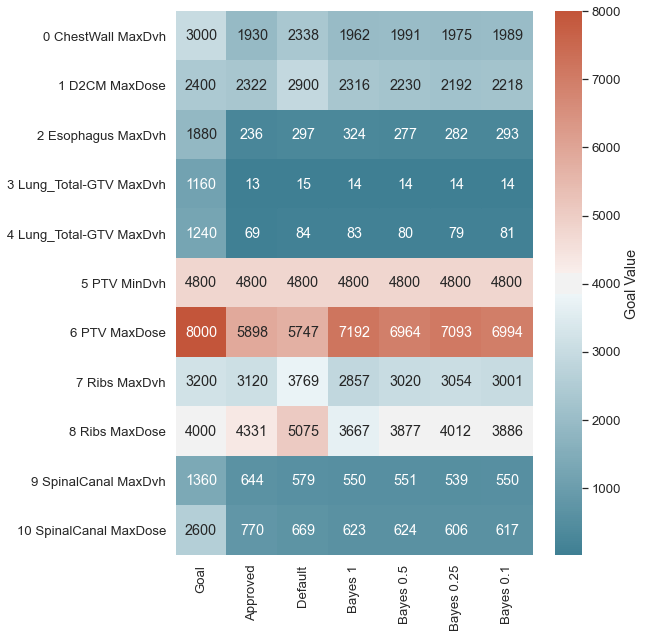

In [29]:
# Compare goal values
#idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
idx_bayes_5 = np.argmin(res_bayes_5.opt_result.func_vals)
idx_bayes_2 = np.argmin(res_bayes_2.opt_result.func_vals)
idx_bayes_1 = np.argmin(res_bayes_1.opt_result.func_vals)
X = np.zeros((len(approved.goal_df), 7))
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
for index, row in approved.goal_df.iterrows():
    X[index, 0] = row['AcceptanceLevel']
    X[index, 1] = approved.goal_dict[index][0]
    X[index, 2] = default.goal_dict[index][0]
    #X[index, 3] = res_dummy.goal_dict[index][idx_dummy]
    X[index, 3] = res_bayes.goal_dict[index][idx_bayes]
    X[index, 4] = res_bayes_5.goal_dict[index][idx_bayes_5]
    X[index, 5] = res_bayes_2.goal_dict[index][idx_bayes_2]
    X[index, 6] = res_bayes_1.goal_dict[index][idx_bayes_1]
Y = pd.DataFrame(columns=['Goal', 'Approved', 'Default', 'Bayes 1', 'Bayes 0.5', 'Bayes 0.25', 'Bayes 0.1'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(8, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Goal Value'},
            fmt=".0f");

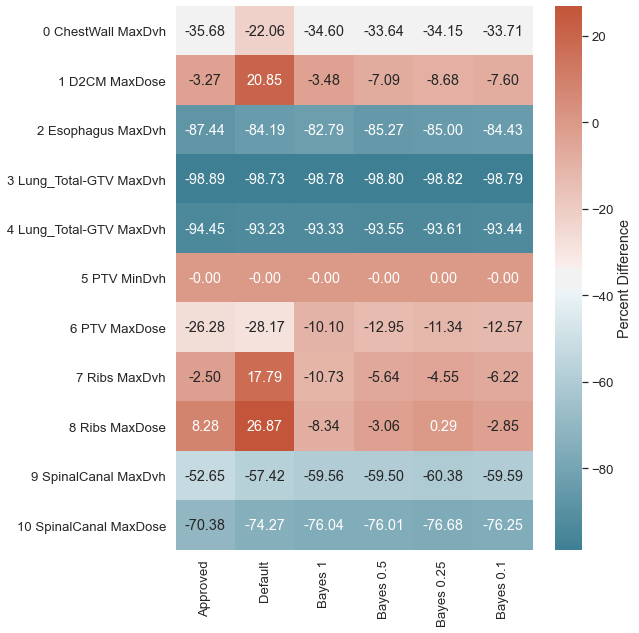

In [32]:
# Compare goal percent difference
X = np.zeros((len(approved.goal_df), 6))
for index, row in approved.goal_df.iterrows():
    X[index, 0] = -raybay.get_term(approved.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 1] = -raybay.get_term(default.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    #X[index, 2] = -raybay.get_term(res_dummy.goal_dict[index][idx_dummy], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 2] = -raybay.get_term(res_bayes.goal_dict[index][idx_bayes], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 3] = -raybay.get_term(res_bayes_5.goal_dict[index][idx_bayes_5], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 4] = -raybay.get_term(res_bayes_2.goal_dict[index][idx_bayes_2], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 5] = -raybay.get_term(res_bayes_1.goal_dict[index][idx_bayes_1], row['AcceptanceLevel'], 'Max', 'linear')
Y = pd.DataFrame(columns=['Approved', 'Default', 'Bayes 1', 'Bayes 0.5', 'Bayes 0.25', 'Bayes 0.1'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(8, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Percent Difference'},
            fmt='.2f');

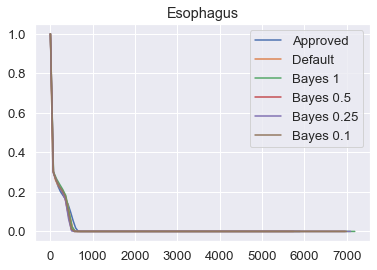

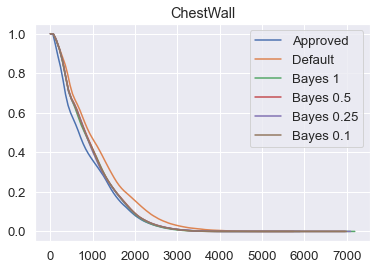

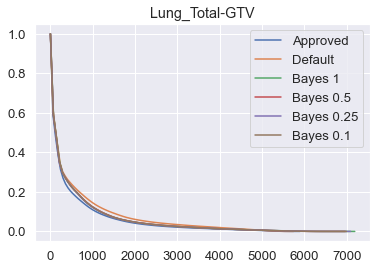

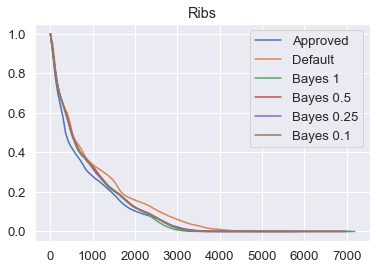

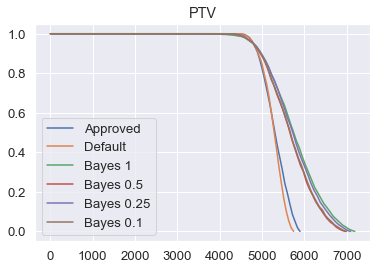

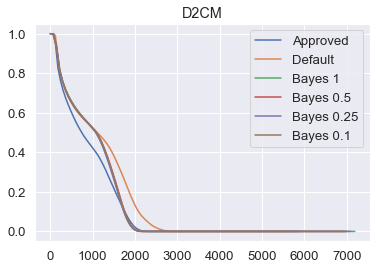

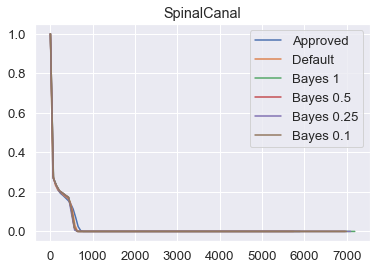

In [33]:
for roi in approved.roi_list:
    plt.figure()
    plt.plot(approved.dvh_dict['Dose'], approved.dvh_dict[roi])
    plt.plot(default.dvh_dict['Dose'], default.dvh_dict[roi])
    #plt.plot(res_dummy.dvh_dict['Dose'], res_dummy.dvh_dict[roi])
    plt.plot(res_bayes.dvh_dict['Dose'], res_bayes.dvh_dict[roi])
    plt.plot(res_bayes_5.dvh_dict['Dose'], res_bayes_5.dvh_dict[roi])
    plt.plot(res_bayes_2.dvh_dict['Dose'], res_bayes_2.dvh_dict[roi])
    plt.plot(res_bayes_1.dvh_dict['Dose'], res_bayes_1.dvh_dict[roi])
    plt.title(roi)
    plt.legend(['Approved', 'Default', 'Bayes 1', 'Bayes 0.5', 'Bayes 0.25', 'Bayes 0.1'])

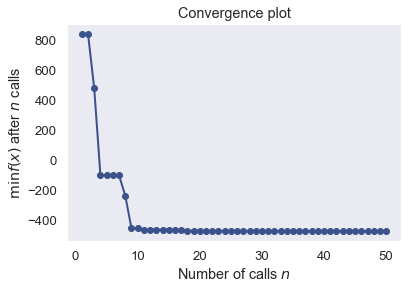

In [34]:
# Convergence of bayes
plots.plot_convergence(res_bayes.opt_result)

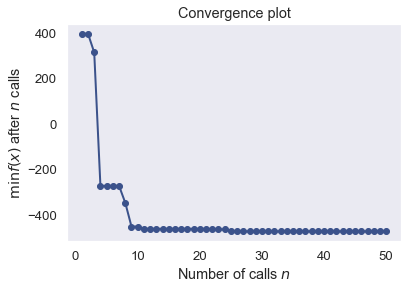

In [10]:
# Convergence of bayes
plots.plot_convergence(res_bayes_5.opt_result)

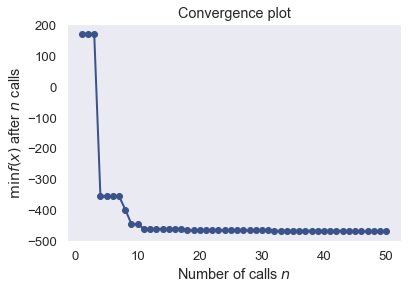

In [11]:
# Convergence of bayes
plots.plot_convergence(res_bayes_2.opt_result)

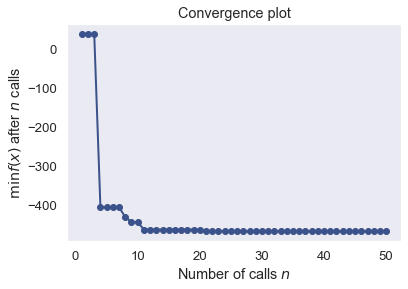

In [12]:
# Convergence of bayes
plots.plot_convergence(res_bayes_1.opt_result)

(-500.0, -400.0)

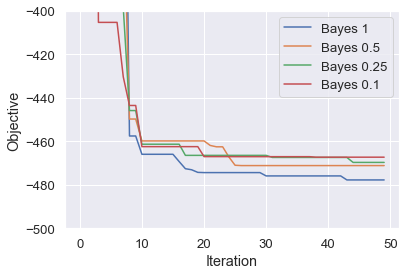

In [35]:
# Convergence of both: due to lower rib weight, objective values are lower
#plt.plot(np.minimum.accumulate(res_dummy.opt_result.func_vals))
plt.plot(np.minimum.accumulate(res_bayes.opt_result.func_vals))
plt.plot(np.minimum.accumulate(res_bayes_5.opt_result.func_vals))
plt.plot(np.minimum.accumulate(res_bayes_2.opt_result.func_vals))
plt.plot(np.minimum.accumulate(res_bayes_1.opt_result.func_vals))
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.legend(['Bayes 1', 'Bayes 0.5', 'Bayes 0.25', 'Bayes 0.1'])
plt.ylim([-500, -400])

(-500.0, -100.0)

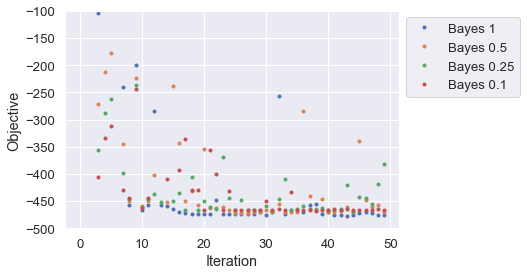

In [36]:
# Sampled objective values
#plt.plot(res_dummy.opt_result.func_vals, '.')
plt.plot(res_bayes.opt_result.func_vals, '.')
plt.plot(res_bayes_5.opt_result.func_vals, '.')
plt.plot(res_bayes_2.opt_result.func_vals, '.')
plt.plot(res_bayes_1.opt_result.func_vals, '.')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.legend(['Bayes 1', 'Bayes 0.5', 'Bayes 0.25', 'Bayes 0.1'], bbox_to_anchor=(1, 1))
plt.ylim([-500, -100])

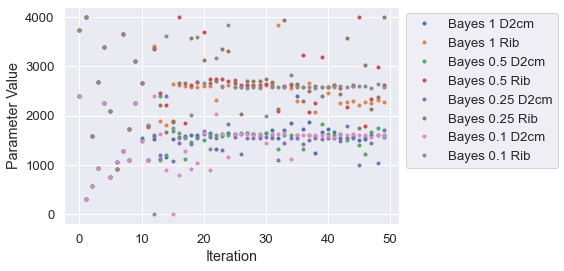

In [37]:
# Sampled parameter values
#plt.plot(res_dummy.opt_result.x_iters, '.')
plt.plot(res_bayes.opt_result.x_iters, '.')
plt.plot(res_bayes_5.opt_result.x_iters, '.')
plt.plot(res_bayes_2.opt_result.x_iters, '.')
plt.plot(res_bayes_1.opt_result.x_iters, '.')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend(['Bayes 1 D2cm',  'Bayes 1 Rib', 'Bayes 0.5 D2cm', 'Bayes 0.5 Rib',
            'Bayes 0.25 D2cm', 'Bayes 0.25 Rib', 'Bayes 0.1 D2cm', 'Bayes 0.1 Rib'], bbox_to_anchor=(1, 1))

<IPython.core.display.Javascript object>


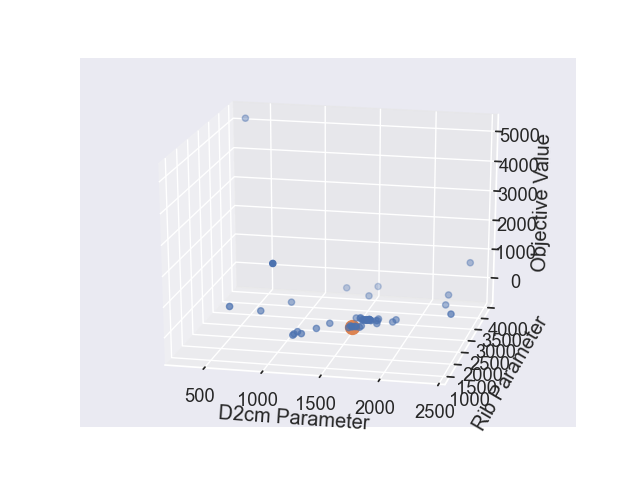

Text(0.5, 0, 'Objective Value')

In [38]:
# Parameters vs. Objective
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.opt_result.func_vals)
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.opt_result.func_vals)
# ax.scatter3D(res_dummy.opt_result.x_iters[idx_dummy][0],
#              res_dummy.opt_result.x_iters[idx_dummy][1], res_dummy.opt_result.fun, s=100)
ax.scatter3D(res_bayes.opt_result.x_iters[idx_bayes][0],
             res_bayes.opt_result.x_iters[idx_bayes][1], res_bayes.opt_result.fun, s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Objective Value')

<IPython.core.display.Javascript object>


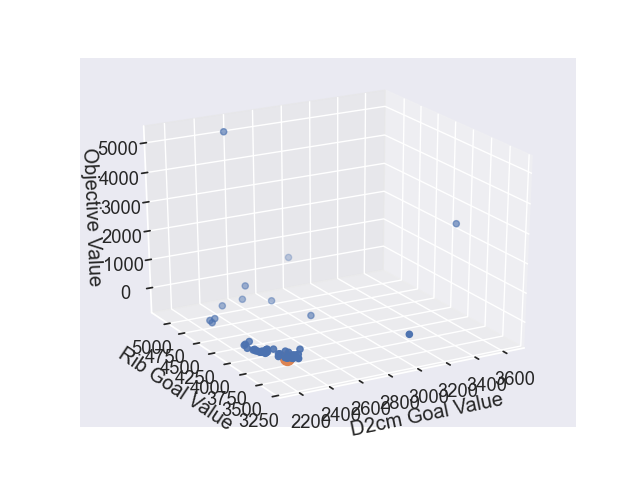

Text(0.5, 0, 'Objective Value')

In [39]:
# Parameters vs. Objective
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(res_dummy.goal_dict[1], res_dummy.goal_dict[8], 
#              res_dummy.opt_result.func_vals)
ax.scatter3D(res_bayes.goal_dict[1], res_bayes.goal_dict[8], 
             res_bayes.opt_result.func_vals)
# ax.scatter3D(res_dummy.goal_dict[1][idx_dummy], res_dummy.goal_dict[8][idx_dummy],
#              res_dummy.opt_result.fun, s=100)
ax.scatter3D(res_bayes.goal_dict[1][idx_bayes], res_bayes.goal_dict[8][idx_bayes],
             res_bayes.opt_result.fun, s=100)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

<IPython.core.display.Javascript object>


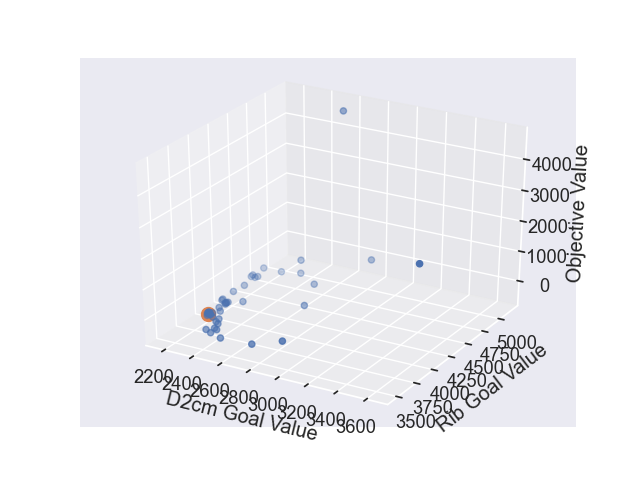

Text(0.5, 0, 'Objective Value')

In [40]:
# Parameters vs. Objective (0.5)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(res_bayes_5.goal_dict[1], res_bayes_5.goal_dict[8], 
             res_bayes_5.opt_result.func_vals)
ax.scatter3D(res_bayes_5.goal_dict[1][idx_bayes_5], res_bayes_5.goal_dict[8][idx_bayes_5],
             res_bayes_5.opt_result.fun, s=100)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

<IPython.core.display.Javascript object>


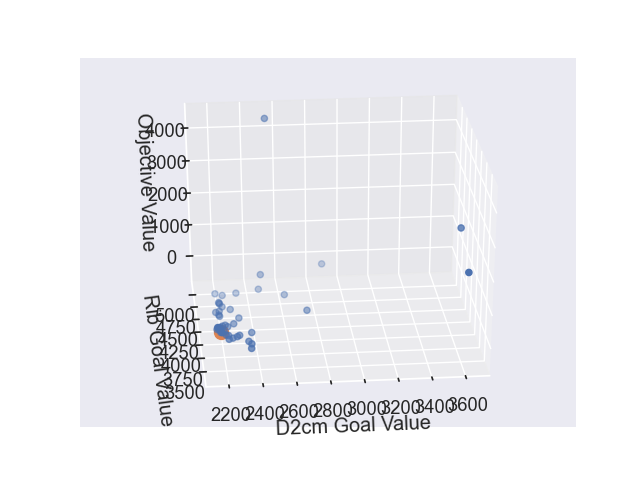

Text(0.5, 0, 'Objective Value')

In [41]:
# Parameters vs. Objective (0.25)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(res_bayes_2.goal_dict[1], res_bayes_2.goal_dict[8], 
             res_bayes_2.opt_result.func_vals)
ax.scatter3D(res_bayes_2.goal_dict[1][idx_bayes_2], res_bayes_2.goal_dict[8][idx_bayes_2],
             res_bayes_2.opt_result.fun, s=100)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

<IPython.core.display.Javascript object>


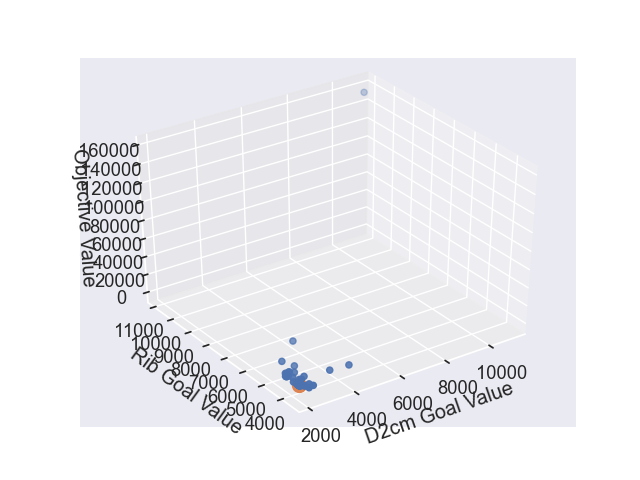

Text(0.5, 0, 'Objective Value')

In [42]:
# Parameters vs. Objective (0.1)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(res_bayes_1.goal_dict[1], res_bayes_1.goal_dict[8], 
             res_bayes_1.opt_result.func_vals)
ax.scatter3D(res_bayes_1.goal_dict[1][idx_bayes_1], res_bayes_1.goal_dict[8][idx_bayes_1],
             res_bayes_1.opt_result.fun, s=100)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

<IPython.core.display.Javascript object>


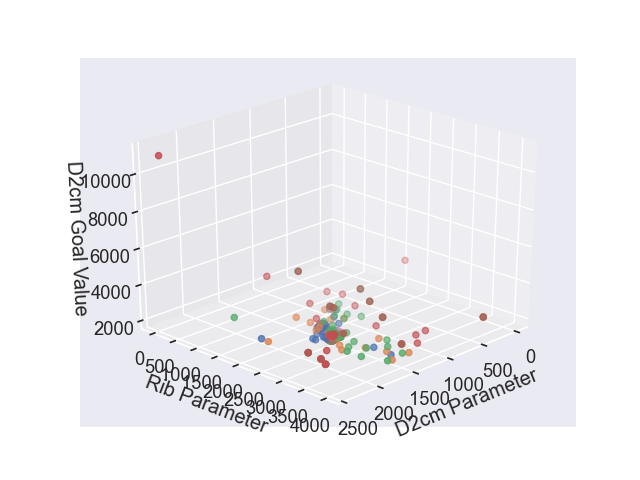

Text(0.5, 0, 'D2cm Goal Value')

In [43]:
# Parameters vs. D2cm Goal
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.goal_dict[1])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[1])
ax.scatter3D([row[0] for row in res_bayes_5.opt_result.x_iters], 
             [row[1] for row in res_bayes_5.opt_result.x_iters], 
             res_bayes_5.goal_dict[1])
ax.scatter3D([row[0] for row in res_bayes_2.opt_result.x_iters], 
             [row[1] for row in res_bayes_2.opt_result.x_iters], 
             res_bayes_2.goal_dict[1])
ax.scatter3D([row[0] for row in res_bayes_1.opt_result.x_iters], 
             [row[1] for row in res_bayes_1.opt_result.x_iters], 
             res_bayes_1.goal_dict[1])
# ax.scatter3D(res_dummy.opt_result.x_iters[idx_dummy][0],
#              res_dummy.opt_result.x_iters[idx_dummy][1], res_dummy.goal_dict[1][idx_dummy], s=100)
ax.scatter3D(res_bayes.opt_result.x_iters[idx_bayes][0],
             res_bayes.opt_result.x_iters[idx_bayes][1], res_bayes.goal_dict[1][idx_bayes], s=100)
ax.scatter3D(res_bayes_5.opt_result.x_iters[idx_bayes_5][0],
             res_bayes_5.opt_result.x_iters[idx_bayes_5][1], res_bayes_5.goal_dict[1][idx_bayes_5], s=100)
ax.scatter3D(res_bayes_2.opt_result.x_iters[idx_bayes_2][0],
             res_bayes_2.opt_result.x_iters[idx_bayes_2][1], res_bayes_2.goal_dict[1][idx_bayes_2], s=100)
ax.scatter3D(res_bayes_1.opt_result.x_iters[idx_bayes_1][0],
             res_bayes_1.opt_result.x_iters[idx_bayes_1][1], res_bayes_1.goal_dict[1][idx_bayes_1], s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('D2cm Goal Value')

<IPython.core.display.Javascript object>


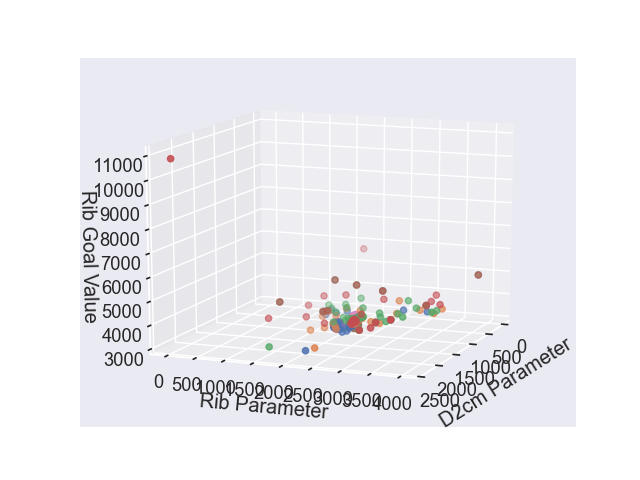

Text(0.5, 0, 'Rib Goal Value')

In [44]:
# Parameters vs. Rib Goal
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.goal_dict[8])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[8])
ax.scatter3D([row[0] for row in res_bayes_5.opt_result.x_iters], 
             [row[1] for row in res_bayes_5.opt_result.x_iters], 
             res_bayes_5.goal_dict[8])
ax.scatter3D([row[0] for row in res_bayes_2.opt_result.x_iters], 
             [row[1] for row in res_bayes_2.opt_result.x_iters], 
             res_bayes_2.goal_dict[8])
ax.scatter3D([row[0] for row in res_bayes_1.opt_result.x_iters], 
             [row[1] for row in res_bayes_1.opt_result.x_iters], 
             res_bayes_1.goal_dict[8])
# ax.scatter3D(res_dummy.opt_result.x_iters[idx_dummy][0],
#              res_dummy.opt_result.x_iters[idx_dummy][1], res_dummy.goal_dict[8][idx_dummy], s=100)
ax.scatter3D(res_bayes.opt_result.x_iters[idx_bayes][0],
             res_bayes.opt_result.x_iters[idx_bayes][1], res_bayes.goal_dict[8][idx_bayes], s=100)
ax.scatter3D(res_bayes_5.opt_result.x_iters[idx_bayes_5][0],
             res_bayes_5.opt_result.x_iters[idx_bayes_5][1], res_bayes_5.goal_dict[8][idx_bayes_5], s=100)
ax.scatter3D(res_bayes_2.opt_result.x_iters[idx_bayes_2][0],
             res_bayes_2.opt_result.x_iters[idx_bayes_2][1], res_bayes_2.goal_dict[8][idx_bayes_2], s=100)
ax.scatter3D(res_bayes_1.opt_result.x_iters[idx_bayes_1][0],
             res_bayes_1.opt_result.x_iters[idx_bayes_1][1], res_bayes_1.goal_dict[8][idx_bayes_1], s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Rib Goal Value')

In [45]:
res_bayes.opt_result.x

[1540.7763280071788, 2265.1763045749603]

In [46]:
res_bayes_5.opt_result.x

[1639.331763909987, 2623.013544291828]

In [47]:
res_bayes_2.opt_result.x

[1544.377895614509, 2589.682299984882]

In [48]:
res_bayes_1.opt_result.x

[1611.8831164345813, 2567.4405139718524]